# Deep Convolutional Generative Adversarial Networks (DCGAN) (Chapter 17) 

---

This notebook implements a **Deep Convolutional GAN (DCGAN)**, which represents a significant architectural upgrade from the basic fully connected GAN. By replacing standard dense layers with **Convolutional** and **Transpose Convolutional** layers, the model becomes significantly more effective at capturing spatial hierarchies in images, allowing for the generation of higher-quality and more stable synthetic data.

### 1. The DCGAN Architecture: Spatial Synthesis 🧱

DCGAN introduces specific architectural constraints that were discovered to stabilize adversarial training:

* **The Generator ($G$):** Uses **Transpose Convolutional layers (`nn.ConvTranspose2d`)**. Unlike standard convolution which downsamples, transpose convolution upsamples a low-dimensional latent vector into a high-resolution image. 
    * It utilizes **Batch Normalization** to stabilize the learning process.
    * Activations are **ReLU** for all layers except the output, which uses **Tanh**.
* **The Discriminator ($D$):** A "mirrored" version of a CNN classifier. It uses **Strided Convolutions** instead of pooling layers to downsample the image.
    * It uses **LeakyReLU** activations to prevent the "dying ReLU" problem during adversarial competition.
    * The final output is a single scalar produced by a **Sigmoid** activation, representing the probability of the image being "real".



### 2. Upsampling and Feature Mapping

The notebook demonstrates the mathematical transition from a 1D latent noise vector to a 3D image tensor:
* **Input:** A noise vector of size (Batch, 100, 1, 1).
* **Transformation:** Successive layers increase the spatial dimensions (e.g., from 1x1 to 4x4, 7x7, 14x14, and finally 28x28 for MNIST) while decreasing the number of feature channels.

### 3. Training Stability and Hyperparameters ⚙️

DCGAN is sensitive to initialization and hyperparameters. This notebook implements the recommended settings from the original DCGAN paper:
* **Weight Initialization:** Weights are initialized from a zero-centered Normal distribution with a standard deviation of 0.02.
* **Optimizer:** **Adam** is used with a specific learning rate (often 0.0002) and a reduced momentum term ($\beta_1 = 0.5$) to prevent oscillation in the adversarial game.
* **Loss Function:** Standard **Binary Cross Entropy (`nn.BCELoss`)** is used to calculate the errors for both the generator and discriminator.



### 4. Results and Visualization

The notebook tracks the quality of the generated images throughout the training epochs:
* **Fixed Noise:** A constant set of latent vectors is used to "check in" on the same generated samples over time.
* **Grid Display:** The results are displayed in a grid, showing how the model moves from generating random static to clear, distinct handwritten digits.
* **Loss Curves:** Includes plots for both $D$ loss and $G$ loss, allowing for an analysis of whether the two networks are maintaining a healthy competitive balance.

This implementation serves as the bridge between basic generative theory and modern, high-resolution deep generative modeling.

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

image_path = './'
mnist_dataset = datasets.MNIST(
    root= image_path,
    train= True,
    download= True,
    transform= transform)

In [ ]:
def generator(input_size, n_filters):
  model = nn.Sequential(
      nn.ConvTranspose2d(input_size, 4*n_filters, kernel_size=4,
                         stride=1, padding=0, bias=False),
      nn.BatchNorm2d(4*n_filters),
      nn.LeakyReLU(0.2),
      nn.ConvTranspose2d(4*n_filters, 2*n_filters, kernel_size= 3,
                         stride= 2, padding= 1, bias= False),
      nn.BatchNorm2d(2*n_filters),
      nn.LeakyReLU(0.2),
      nn.ConvTranspose2d(2*n_filters, n_filters, kernel_size= 4,
                         stride= 2, padding= 1, bias= False),
      nn.BatchNorm2d(n_filters),
      nn.LeakyReLU(0.2),
      nn.ConvTranspose2d(n_filters, 1, kernel_size= 4, stride= 2, padding= 1, bias= False),
      nn.Tanh()
  )

  return model

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, n_filters):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(1, n_filters, kernel_size= 4, stride= 2, padding= 1, bias= False),
        nn.LeakyReLU(0.2),
        nn.Conv2d(n_filters, 2*n_filters, kernel_size= 4, stride= 2, padding= 1, bias= False),
        nn.BatchNorm2d(2*n_filters),
        nn.LeakyReLU(0.2),
        nn.Conv2d(2*n_filters, 4*n_filters, kernel_size= 3, stride= 2, padding= 1, bias= False),
        nn.BatchNorm2d(4*n_filters),
        nn.LeakyReLU(0.2),
        nn.Conv2d(4*n_filters, 1, kernel_size= 4, stride= 1, padding= 0, bias= False),
        nn.Sigmoid()
    )

  def forward(self, input):
    output = self.network(input)
    return output.view(-1, 1).squeeze(0)

In [ ]:
z_size = 100
n_filters = 32
mode_z = 'uniform'
image_size = (28, 28)
gen_model = generator(z_size, n_filters).to(device)
print(gen_model)

Sequential(
  (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2)
  (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): Tanh()
)


In [ ]:
disc_model = Discriminator(n_filters).to(device)
print(disc_model)

Discriminator(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [ ]:
batch_size = 32
mnist_dl = DataLoader(
    mnist_dataset,
    batch_size= batch_size,
    shuffle= False)

In [ ]:
loss_fn = nn.BCELoss()
gen_optimizer = optim.Adam(gen_model.parameters(), 0.0003, betas= (0.5, 0.999))
disc_optimizer = optim.Adam(disc_model.parameters(), 0.0002, betas= (0.5, 0.999))

In [ ]:
def create_noise(batch_size, z_size, mode_z):
  if mode_z == 'uniform':
    input_z = torch.rand(batch_size, z_size, 1 , 1)*2 - 1
  if mode_z == 'normal':
    input_z = torch.randn(batch_size, z_size, 1, 1)
  return input_z

In [ ]:
def disc_train(x):
  disc_model.zero_grad()
  batch_size = x.size(0)
  x = x.to(device)
  d_labels_real = torch.ones(batch_size, 1, device= device)
  d_prob_real = disc_model(x)
  d_loss_real = loss_fn(d_prob_real, d_labels_real)
  input_z = create_noise(batch_size, z_size, mode_z).to(device)
  g_ouptput = gen_model(input_z)
  d_prob_fake = disc_model(g_ouptput)
  d_labels_fake = torch.zeros(batch_size, 1, device= device)
  d_loss_fake = loss_fn(d_prob_fake, d_labels_fake)
  d_loss = d_loss_real + d_loss_fake
  d_loss.backward()
  disc_optimizer.step()
  return d_loss.item(), d_prob_real.detach(), d_prob_fake.detach()

In [ ]:
def gen_train(x):
  gen_model.zero_grad()
  batch_size = x.size(0)
  input_z = create_noise(batch_size, z_size, mode_z).to(device)
  g_output = gen_model(input_z)
  d_prob_fake = disc_model(g_output)
  g_prob_real = torch.ones(batch_size, 1, device= device)
  g_loss = loss_fn(d_prob_fake, g_prob_real)
  g_loss.backward()
  gen_optimizer.step()
  return g_loss.data.item()

In [ ]:
def create_samples(gen_model, input_z):
  g_output = gen_model(input_z)
  images = torch.reshape(g_output, (batch_size, *image_size))
  return (images+1)/2.0

In [ ]:
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)
epoch_samples = []
all_d_losses, all_g_losses = [], []
all_d_real, all_d_fake = [], []
epochs = 100
torch.manual_seed(1)
for epoch in range(1, epochs+1):
  gen_model.train()
  d_losses, g_losses = [], []
  for i, (x, _) in enumerate(mnist_dl):
    d_loss, d_prob_real, d_prob_fake = disc_train(x)
    d_losses.append(d_loss)
    g_loss = gen_train(x)
    g_losses.append(g_loss)
  print(f'Epoch {epoch:03d} | Average Losses >> '
        f'G/D {torch.FloatTensor(g_losses).mean():.4f}'
        f'/{torch.FloatTensor(d_losses).mean():.4f}')
  gen_model.eval()
  epoch_samples.append(
        create_samples(gen_model, fixed_z).detach().cpu().numpy()
    )

Epoch 001 | Average Losses >> G/D 1.8962/0.6311
Epoch 002 | Average Losses >> G/D 2.3231/0.4992
Epoch 003 | Average Losses >> G/D 2.5061/0.4580
Epoch 004 | Average Losses >> G/D 2.7091/0.3925
Epoch 005 | Average Losses >> G/D 2.8667/0.3620
Epoch 006 | Average Losses >> G/D 3.0223/0.3384
Epoch 007 | Average Losses >> G/D 3.1848/0.3003
Epoch 008 | Average Losses >> G/D 3.2768/0.2928
Epoch 009 | Average Losses >> G/D 3.4650/0.2695
Epoch 010 | Average Losses >> G/D 3.4609/0.2742
Epoch 011 | Average Losses >> G/D 3.5643/0.2532
Epoch 012 | Average Losses >> G/D 3.7645/0.2285
Epoch 013 | Average Losses >> G/D 3.7460/0.2405
Epoch 014 | Average Losses >> G/D 3.8503/0.2219
Epoch 015 | Average Losses >> G/D 4.0231/0.1938
Epoch 016 | Average Losses >> G/D 4.0298/0.2132
Epoch 017 | Average Losses >> G/D 4.0583/0.2001
Epoch 018 | Average Losses >> G/D 4.2381/0.1816
Epoch 019 | Average Losses >> G/D 4.2086/0.1984
Epoch 020 | Average Losses >> G/D 4.2887/0.1764
Epoch 021 | Average Losses >> G/D 4.3050

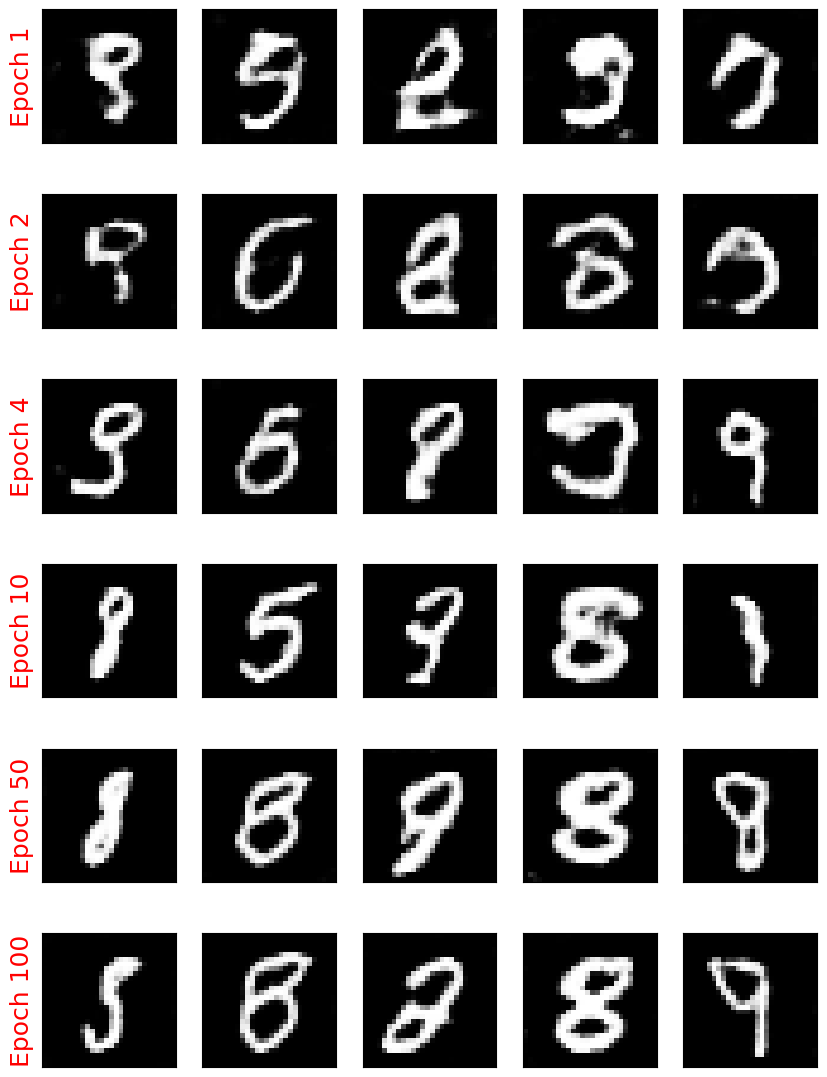

In [ ]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize= (10, 14))
for i, e in enumerate(selected_epochs):
  for j in range(5):
    ax = fig.add_subplot(6, 5, i*5+j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    if j == 0:
      ax.text(-0.06, 0.5, f'Epoch {e}',
              rotation=90, size=18, color='red',
              horizontalalignment='right',
              verticalalignment='center',
              transform=ax.transAxes)
    image = epoch_samples[e-1][j]
    ax.imshow(image, cmap= 'gray')

plt.show()